In [1]:
import numpy as np
import os
import PIL.Image as Image

from datetime import datetime
from tqdm import tqdm_notebook as tqdm
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.datasets as datasets
from torch.utils.data import DataLoader
from torch.autograd import Variable
import torchvision.transforms as transforms
from IPython import display
import matplotlib.pylab as plt
import ipywidgets

In [2]:
if torch.cuda.is_available():
    print("The code will run on GPU.")
else:
    print("The code will run on CPU.")
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

The code will run on GPU.


In [3]:
class Horses(torch.utils.data.Dataset):
    def __init__(self, train, transform, data_path='/scratch/horse2zebra'):
        'Initialization'
        self.transform    = transform
        
        data_path         = os.path.join(data_path, 'train' if train else 'test')
        data_path         = os.path.join(data_path, 'A')
        list_files_horses = os.listdir(data_path)
        self.image_paths  = [os.path.join(data_path, file) for file in list_files_horses]
        
    def __len__(self):
        'Returns the total number of samples'
        return len(self.image_paths)

    def __getitem__(self, idx):
        'Generates one sample of data'
        image_path = self.image_paths[idx]
        image = Image.open(image_path)
        X = self.transform(image)
        return X

In [4]:
class Zebras(torch.utils.data.Dataset):
    def __init__(self, train, transform, data_path='/scratch/horse2zebra'):
        'Initialization'
        self.transform    = transform
        data_path         = os.path.join(data_path, 'train' if train else 'test')
        data_path         = os.path.join(data_path, 'B')
        list_files_zebras = os.listdir(data_path)
        self.image_paths  = [os.path.join(data_path, file) for file in list_files_zebras]
        
        self.image_paths
        
    def __len__(self):
        'Returns the total number of samples'
        return len(self.image_paths)

    def __getitem__(self, idx):
        'Generates one sample of data'
        image_path = self.image_paths[idx]
        image = Image.open(image_path).convert('RGB')
        X = self.transform(image)
        return X

In [13]:
batch_size = 1
size = 256

transformer_train_horses = transforms.Compose([
#     transforms.Grayscale(3),
    transforms.Resize(size),
    transforms.ToTensor(),
    transforms.Normalize((.5,), (.5,))
])

transformer_train_zebras = transforms.Compose([
#     transforms.Grayscale(3),
    transforms.Resize(size),
    transforms.ToTensor(),
    transforms.Normalize((.5,), (.5,))
])

transformer_test_horses = transforms.Compose([
#     transforms.Grayscale(3),
    transforms.Resize(size),
    transforms.ToTensor(),
    transforms.Normalize((.5,), (.5,))
])

transformer_test_zebras = transforms.Compose([
#     transforms.Grayscale(3),
    transforms.Resize(size),
    transforms.ToTensor(),
    transforms.Normalize((.5,), (.5,))
])

train_set_horses    = Horses(True, transformer_train_horses)
train_loader_horses = DataLoader(train_set_horses, batch_size=batch_size, shuffle=True, num_workers=3)

test_set_horses     = Horses(False, transformer_test_horses)
test_loader_horses  = DataLoader(test_set_horses, batch_size=batch_size, shuffle=True, num_workers=3)

train_set_zebras    = Zebras(True, transformer_train_zebras)
train_loader_zebras = DataLoader(train_set_zebras, batch_size=batch_size, shuffle=True, num_workers=3)

test_set_zebras     = Zebras(False, transformer_test_zebras)
test_loader_zebras  = DataLoader(test_set_zebras, batch_size=batch_size, shuffle=True, num_workers=3)

<hr>

<h2> Networks

In [14]:
class ResNetBlock(nn.Module):
    def __init__(self, n_features):
        super(ResNetBlock, self).__init__()
        self.resblock = nn.Sequential(
            nn.Conv2d(n_features,n_features, kernel_size=3, stride=1, padding=1),
            nn.InstanceNorm2d(n_features),
            nn.ReLU(inplace=True),
            nn.Conv2d(n_features,n_features, kernel_size=3, stride=1, padding=1),
            nn.InstanceNorm2d(n_features)
        )
    
    def forward(self, x):
        x = self.resblock(x) + x
        return x

In [15]:
class CGAN_G(nn.Module):
    def __init__(self):
        super(CGAN_G, self).__init__()
        
        # encoder
        self.hidden0 = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=7, stride=1, padding=3),
            nn.InstanceNorm2d(64),
            nn.ReLU(inplace=True)
        )
        self.hidden1 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1),
            nn.InstanceNorm2d(64),
            nn.ReLU(inplace=True)
        )
        self.hidden2 = nn.Sequential(
            nn.Conv2d(128, 256, kernel_size=3, stride=2, padding=1),
            nn.InstanceNorm2d(64),
            nn.ReLU(inplace=True)
        )
        
        # transformer
        num_res_blocks = 9
        conv_layers = [nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1)]
        for i in range(num_res_blocks):
            conv_layers.append(ResNetBlock(256))
        self.res_blocks = nn.Sequential(*conv_layers)
        
        # decoder
        self.hidden3 = nn.Sequential(
            nn.ConvTranspose2d(256, 128, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.InstanceNorm2d(64),
            nn.ReLU(inplace=True)
        )
        self.hidden4 = nn.Sequential(
            nn.ConvTranspose2d(128, 64, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.InstanceNorm2d(64),
            nn.ReLU(inplace=True)
        )
        self.hidden5 = nn.Sequential(
            nn.ConvTranspose2d(64, 3, kernel_size=7, stride=1, padding=3), #padding=1?
            nn.Tanh()
        )
        
    def forward(self, x):
        x = self.hidden0(x)
        x = self.hidden1(x)
        x = self.hidden2(x)
        x = self.res_blocks(x)
        x = self.hidden3(x)
        x = self.hidden4(x)
        x = self.hidden5(x)
        return x

In [16]:
class CGAN_D(nn.Module):
    def __init__(self):
        super(CGAN_D, self).__init__()
        
        self.hidden0 = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=4, stride=2, padding=1),
            nn.InstanceNorm2d(64),
            nn.LeakyReLU(.2, inplace=True)
        )
        self.hidden1 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1),
            nn.InstanceNorm2d(128),
            nn.LeakyReLU(.2, inplace=True),
        )
        self.hidden2 = nn.Sequential(
            nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1),
            nn.InstanceNorm2d(256),
            nn.LeakyReLU(.2, inplace=True)
        )
        self.hidden3 = nn.Sequential(
            nn.Conv2d(256, 512, kernel_size=4, stride=1, padding=1),
            nn.InstanceNorm2d(512),
            nn.LeakyReLU(.2, inplace=True),
        )
        self.out = nn.Sequential(
            nn.Conv2d(512, 1, kernel_size=4, stride=1, padding=1)
        )
        
    def forward(self, x):
        x = self.hidden0(x)
        x = self.hidden1(x)
        x = self.hidden2(x)
        x = self.hidden3(x)
        x = self.out(x)
        return x

Output()

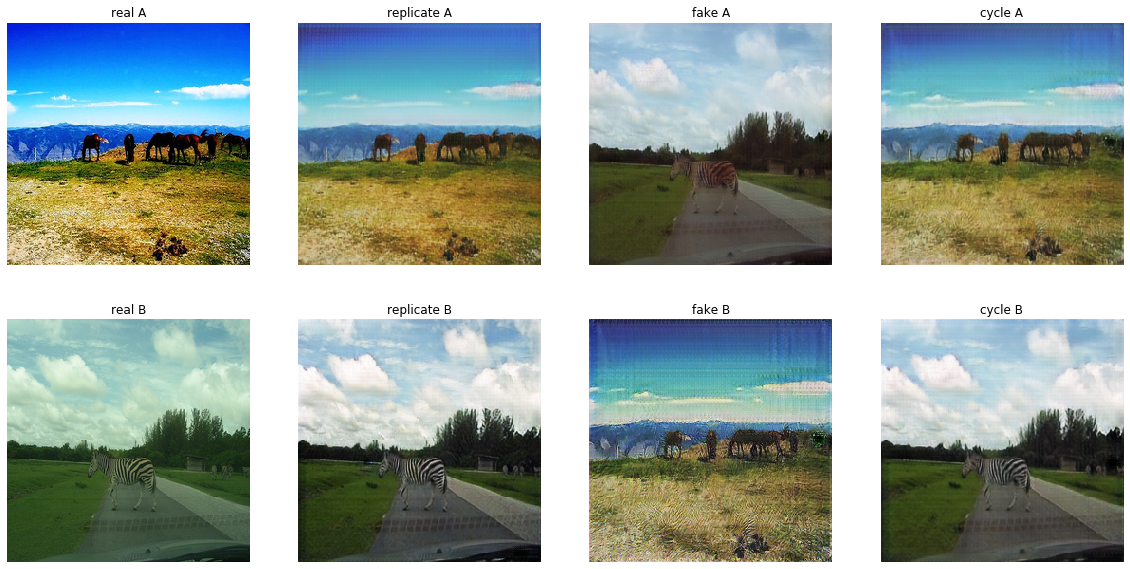

In [19]:
#Initialize networks
D_A   = CGAN_D().to(device)
D_B   = CGAN_D().to(device)
G_A2B = CGAN_G().to(device)
G_B2A = CGAN_G().to(device)

pretrained = True
save_state = True
if pretrained:
    D_A.load_state_dict(torch.load('netD_A_bis.pth'))
    D_B.load_state_dict(torch.load('netD_B_bis.pth'))
    G_A2B.load_state_dict(torch.load('netG_A2B_bis.pth'))
    G_B2A.load_state_dict(torch.load('netG_B2A_bis.pth'))

# optimizers
d_opt_A   = torch.optim.Adam(D_A.parameters(), 0.0002, (0.5, 0.999))
g_opt_A2B = torch.optim.Adam(G_A2B.parameters(), 0.0001, (0.5, 0.999))
d_opt_B   = torch.optim.Adam(D_B.parameters(), 0.0002, (0.5, 0.999))
g_opt_B2A = torch.optim.Adam(G_B2A.parameters(), 0.0001, (0.5, 0.999))

# losses
criterion_gan   = torch.nn.MSELoss()
criterion_cycle = torch.nn.L1Loss()
criterion_id    = torch.nn.L1Loss()

target_real = Variable(torch.cuda.FloatTensor(batch_size).fill_(1.0), requires_grad=False)
target_fake = Variable(torch.cuda.FloatTensor(batch_size).fill_(0.0), requires_grad=False)

# lambdas
lambda_identity = 5
lambda_cycle    = 10

#Clean up all old variables on the GPU no longer in use
torch.cuda.empty_cache()

num_epochs = 2
visualization = ipywidgets.Output()
display.display(visualization)

with visualization:
    plt.figure(figsize=(20,10))
subplots = [plt.subplot(2, 4, k+1) for k in range(8)]

losses = {
    "loss_identity_B": [],
    "loss_identity_A": [],
    "loss_gan_A2B":    [],
    "loss_gan_B2A":    [],
    "loss_cycle_ABA":  [],
    "loss_cycle_BAB":  [],
    "total_loss":      [],
    "loss_discrim_A":  [],
    "loss_discrim_B":  []
}

for epoch in tqdm(range(num_epochs), unit='epoch'):
    for minibatch_nb, (real_A, real_B) in tqdm(enumerate(zip(train_loader_horses, train_loader_zebras)), total=len(train_loader_horses)):
        real_A = real_A.to(device)
        real_B = real_B.to(device)
        
        g_opt_A2B.zero_grad()
        g_opt_B2A.zero_grad()
        
        ### identity losses
        replicate_B       = G_A2B(real_B)
        loss_identity_B   = criterion_id(replicate_B, real_B) * lambda_identity
        
        replicate_A       = G_B2A(real_A)
        loss_identity_A   = criterion_id(replicate_A, real_A) * lambda_identity
        
        ### transform losses
        fake_B            = G_A2B(real_A)
        prediction_fake_B = D_B(fake_B)
        loss_gan_A2B      = criterion_gan(prediction_fake_B, target_real)
        
        fake_A            = G_B2A(real_B)
        prediction_fake_A = D_A(fake_A)
        loss_gan_B2A      = criterion_gan(prediction_fake_A, target_real)
        
        ### cycle losses
        cycle_A           = G_B2A(fake_B)
        loss_cycle_ABA    = criterion_cycle(cycle_A, real_A) * lambda_cycle
        
        cycle_B           = G_A2B(fake_A)
        loss_cycle_BAB    = criterion_cycle(cycle_B, real_B) * lambda_cycle
        
        ### total loss
        loss_G = loss_identity_A + loss_identity_B + loss_gan_A2B + loss_gan_B2A + loss_cycle_ABA + loss_cycle_BAB
        loss_G.backward()
        g_opt_A2B.step()
        g_opt_B2A.step()
        
        ### discriminator A
        d_opt_A.zero_grad()
        
        prediction_real_A = D_A(real_A)
        loss_real_A       = criterion_gan(prediction_real_A, target_real)
        
        fake_A            = G_B2A(real_B)
        prediction_fake_A = D_A(fake_A)
        loss_fake_A       = criterion_gan(prediction_fake_A, target_fake)
        
        loss_D_A = (loss_real_A + loss_fake_A) * lambda_identity
        losses["loss_discrim_A"].append(loss_D_A)
        loss_D_A.backward()
        d_opt_A.step()
        
        ### discriminator B
        d_opt_B.zero_grad()
        
        prediction_real_B = D_B(real_B)
        loss_real_B       = criterion_gan(prediction_real_B, target_real)
        
        fake_B            = G_A2B(real_A)
        prediction_fake_B = D_B(fake_B)
        loss_fake_B       = criterion_gan(prediction_fake_B, target_fake)
        
        loss_D_B = (loss_real_B + loss_fake_B) * lambda_identity
        losses["loss_discrim_B"].append(loss_D_B)
        loss_D_B.backward()
        d_opt_B.step()
        
        if minibatch_nb % 100 == 0:
            with torch.no_grad(), visualization:
                G_A2B.eval()
                G_B2A.eval()
                D_A.eval()
                D_B.eval()
                
                real_A = next(iter(test_loader_horses)).to(device)
                real_B = next(iter(test_loader_zebras)).to(device)
                
                fake_A = G_B2A(real_B)
                replicate_A = G_B2A(real_A)

                fake_B = G_A2B(real_A)
                replicate_B = G_A2B(real_B)

                cycle_A = G_B2A(fake_B)
                cycle_B = G_A2B(fake_A)

                subplots[0].imshow(real_A.cpu().squeeze(0).permute(1,2,0)/2 + .5)
                subplots[0].set_title("real A")
                subplots[0].axis("off")

                subplots[1].imshow(replicate_A.cpu().detach().squeeze(0).permute(1,2,0)/2 + .5)
                subplots[1].set_title("replicate A")
                subplots[1].axis("off")

                subplots[2].imshow(fake_A.cpu().detach().squeeze(0).permute(1,2,0)/2 + .5)
                subplots[2].set_title("fake A")
                subplots[2].axis("off")

                subplots[3].imshow(cycle_A.cpu().detach().squeeze(0).permute(1,2,0)/2 + .5)
                subplots[3].set_title("cycle A")
                subplots[3].axis("off")

                subplots[4].imshow(real_B.cpu().squeeze(0).permute(1,2,0)/2 + .5)
                subplots[4].set_title("real B")
                subplots[4].axis("off")

                subplots[5].imshow(replicate_B.cpu().detach().squeeze(0).permute(1,2,0)/2 + .5)
                subplots[5].set_title("replicate B")
                subplots[5].axis("off")

                subplots[6].imshow(fake_B.cpu().detach().squeeze(0).permute(1,2,0)/2 + .5)
                subplots[6].set_title("fake B")
                subplots[6].axis("off")

                subplots[7].imshow(cycle_B.cpu().detach().squeeze(0).permute(1,2,0)/2 + .5)
                subplots[7].set_title("cycle B")
                subplots[7].axis("off")

                display.display(plt.gcf())
                display.clear_output(wait=True)
                
    losses["loss_identity_B"].append(loss_identity_B)
    losses["loss_identity_A"].append(loss_identity_A)
    losses["loss_gan_A2B"].append(loss_gan_A2B)
    losses["loss_gan_B2A"].append(loss_gan_B2A)
    losses["loss_cycle_ABA"].append(loss_cycle_ABA)
    losses["loss_cycle_BAB"].append(loss_cycle_BAB)
    losses["total_loss"].append(loss_G)
                
    if save_state:
        torch.save(G_A2B.state_dict(), 'netG_A2B_bis.pth')
        torch.save(G_B2A.state_dict(), 'netG_B2A_bis.pth')
        torch.save(D_A.state_dict(), 'netD_A_bis.pth')
        torch.save(D_B.state_dict(), 'netD_B_bis.pth')

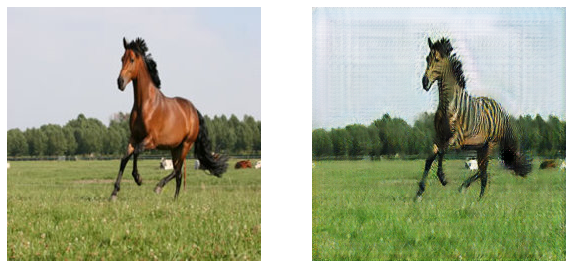

In [185]:
G_A2B.load_state_dict(torch.load('netG_A2B_bis.pth')) # loading model

real_A = next(iter(test_loader_horses)).to(device)

plt.figure(figsize=(10,5));
subplots = [plt.subplot(1, 2, k+1) for k in range(2)];

subplots[0].imshow(real_A.cpu().detach().squeeze(0).permute(1,2,0)/2 + .5);
subplots[0].axis("off");
subplots[1].imshow(G_A2B(real_A).cpu().detach().squeeze(0).permute(1,2,0)/2 + .5);
subplots[1].axis("off");
plt.savefig("horse_2_zebra.png");

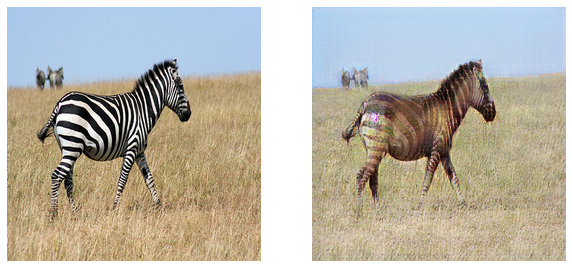

In [85]:
G_B2A.load_state_dict(torch.load('netG_B2A_bis.pth')) # loading model

real_B = next(iter(test_loader_zebras)).to(device)

plt.figure(figsize=(10,5));
subplots = [plt.subplot(1, 2, k+1) for k in range(2)];

subplots[0].imshow(real_B.cpu().detach().squeeze(0).permute(1,2,0)/2 + .5);
subplots[0].axis("off");
subplots[1].imshow(G_B2A(real_B).cpu().detach().squeeze(0).permute(1,2,0)/2 + .5);
subplots[1].axis("off");
plt.savefig("zebras_2_horse.png");

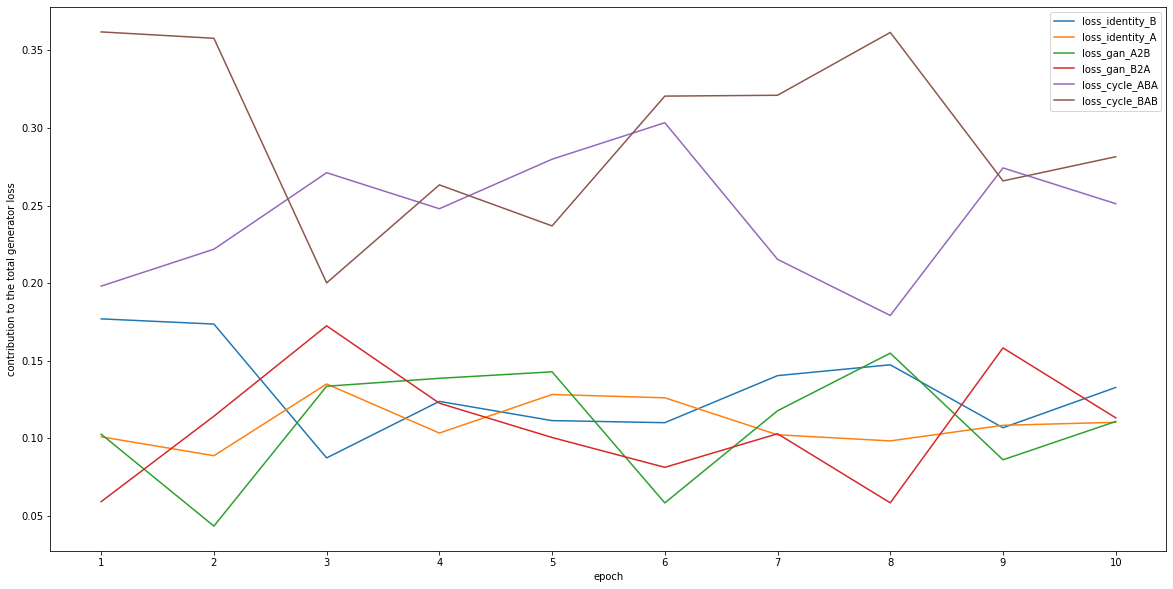

In [49]:
plt.figure(figsize=(20,10))

for i, key in enumerate(list(losses.keys())[:6]):
    contribution_loss = [(loss / total_loss).item() for (loss, total_loss) in zip(losses[key], losses["total_loss"])]
    plt.plot(range(len(contribution_loss)), contribution_loss, label=key)
plt.xlabel("epoch");
plt.xticks(range(0,10), range(1,11));
plt.ylabel("contribution to the total generator loss");
plt.legend();
plt.savefig("contribution_epoch_generator.png");

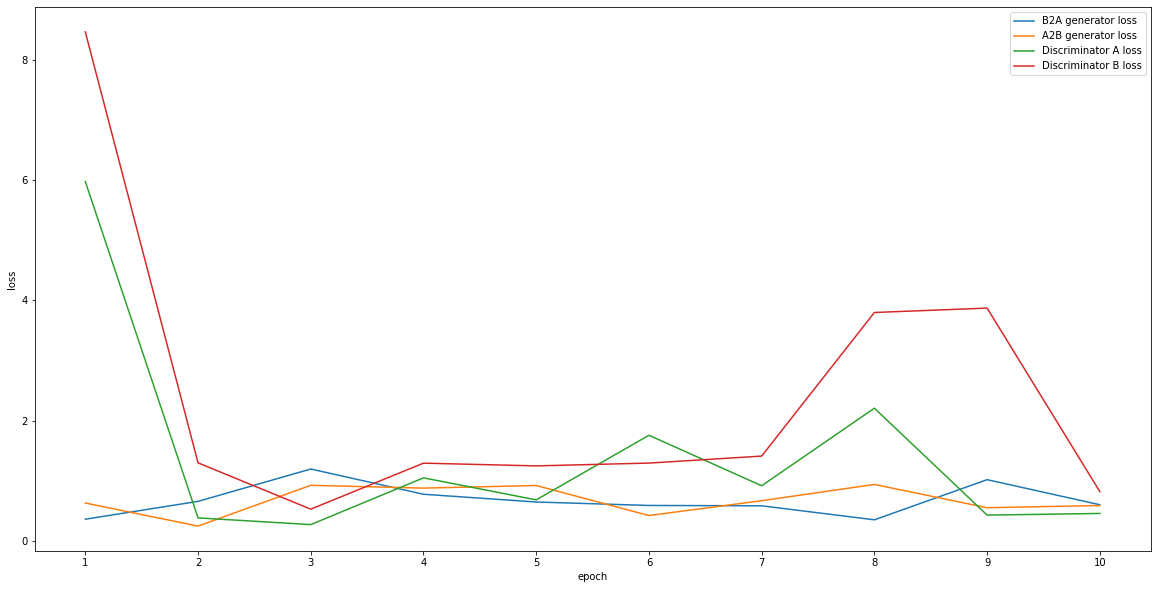

In [70]:
plt.figure(figsize=(20,10))
plt.plot(range(len(losses['total_loss'])), losses['loss_gan_B2A'], label="B2A generator loss")
plt.plot(range(len(losses['total_loss'])), losses['loss_gan_A2B'], label="A2B generator loss")
plt.plot(range(len(losses['total_loss'])), losses["loss_discrim_A"][::1067], label="Discriminator A loss")
plt.plot(range(len(losses['total_loss'])), losses["loss_discrim_B"][::1067], label="Discriminator B loss")
plt.xlabel("epoch");
plt.ylabel("loss")
plt.xticks(range(0,10), range(1,11));
plt.legend();
plt.savefig("generators_vs_discrimnators_loss.png")